Classification: Prédiction du diabète (étiquette binaire)

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [103]:
# ------------------------------------------------------------------------------
# 1. Chargement des données
# ------------------------------------------------------------------------------
print("1-CHARGEMENT : Lecture du fichier 'diabetes.csv'...")
data = pd.read_csv("diabetes.csv")
print("Aperçu des données :\n", data.head())
print(f"Dimensions du dataset : {data.shape}")
print(f"Colonnes : {data.columns.tolist()}")

1-CHARGEMENT : Lecture du fichier 'diabetes.csv'...
Aperçu des données :
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Dimensions du dataset : (768, 9)
Colonnes : ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


In [104]:
# ------------------------------------------------------------------------------
# 2. Nettoyage et prétraitement
# ------------------------------------------------------------------------------
print("\n2-NETTOYAGE : Gestion des zéros/missing et vérification...")


2-NETTOYAGE : Gestion des zéros/missing et vérification...


In [71]:
# **Valeurs manquantes**
missing_values = data.isnull().sum()
print("Valeurs manquantes par colonne :\n", missing_values)

Valeurs manquantes par colonne :
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [72]:
# **Gestion des zéros impossibles dans les variables cliniques**
colonnes_zero_impossible = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("\nValeurs zéro dans les mesures cliniques (biologiquement impossibles) :")
for col in colonnes_zero_impossible:
    if col in data.columns:
        nb_zeros = (data[col] == 0).sum()
        pourcentage = nb_zeros / len(data) * 100
        print(f"   {col}: {nb_zeros} zéros ({pourcentage:.1f}%)")


Valeurs zéro dans les mesures cliniques (biologiquement impossibles) :
   Glucose: 5 zéros (0.7%)
   BloodPressure: 35 zéros (4.6%)
   SkinThickness: 227 zéros (29.6%)
   Insulin: 374 zéros (48.7%)
   BMI: 11 zéros (1.4%)


In [73]:
# **Remplacer les zéros par NaN puis par la médiane**
data_clean = data.copy()
for col in colonnes_zero_impossible:
    if col in data.columns:
        data_clean[col] = data_clean[col].replace(0, np.nan)
        mediane = data_clean[col].median()
        data_clean[col].fillna(mediane, inplace=True)
        print(f"   Zéros remplacés par médiane ({mediane:.1f}) dans {col}")

   Zéros remplacés par médiane (117.0) dans Glucose
   Zéros remplacés par médiane (72.0) dans BloodPressure
   Zéros remplacés par médiane (29.0) dans SkinThickness
   Zéros remplacés par médiane (125.0) dans Insulin
   Zéros remplacés par médiane (32.3) dans BMI


In [74]:
print("\nAprès nettoyage - valeurs manquantes :")
print(data_clean.isnull().sum())


Après nettoyage - valeurs manquantes :
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [75]:
# ------------------------------------------------------------------------------
# 3. EDA et déséquilibre
# ------------------------------------------------------------------------------
print("\n3-EDA : Analyse exploratoire et déséquilibre des classes...")


3-EDA : Analyse exploratoire et déséquilibre des classes...


Text(0, 0.5, 'Nombre de patients')

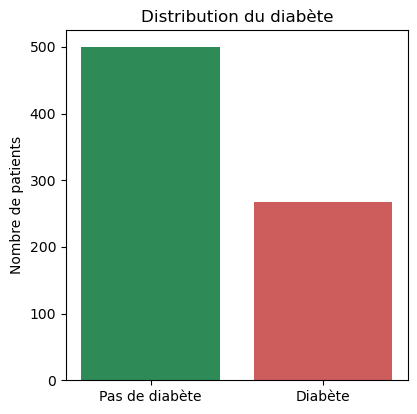

In [76]:
# **Distribution des classes**
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
class_counts = data_clean['Outcome'].value_counts()
plt.bar(['Pas de diabète', 'Diabète'], class_counts.values, color=['#2E8B57', '#CD5C5C'])
plt.title('Distribution du diabète')
plt.ylabel('Nombre de patients')

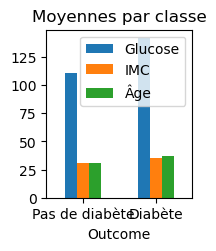

In [77]:
# **Comparaison des moyennes par classe**
plt.subplot(2, 3, 2)
moyennes_par_classe = data_clean.groupby('Outcome')[['Glucose', 'BMI', 'Age']].mean()
moyennes_par_classe.plot(kind='bar', ax=plt.gca())
plt.title('Moyennes par classe')
plt.xticks([0, 1], ['Pas de diabète', 'Diabète'], rotation=0)
plt.legend(['Glucose', 'IMC', 'Âge'])

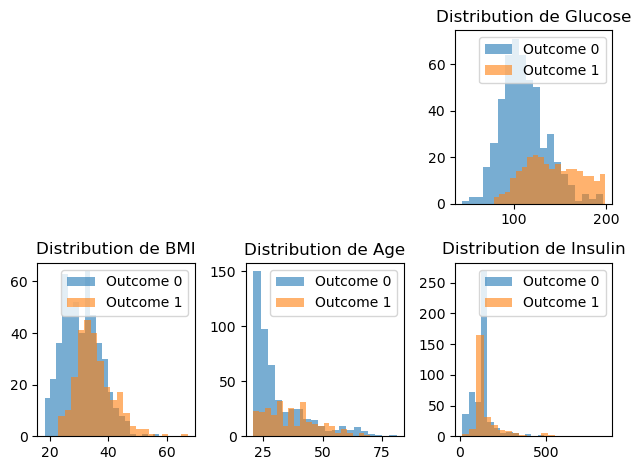

In [78]:
# **Histogrammes des variables principales**
variables_principales = ['Glucose', 'BMI', 'Age', 'Insulin']
for i, var in enumerate(variables_principales):
    plt.subplot(2, 3, i+3)
    for outcome in [0, 1]:
        subset = data_clean[data_clean['Outcome'] == outcome][var]
        plt.hist(subset, alpha=0.6, label=f'Outcome {outcome}', bins=20)
    plt.title(f'Distribution de {var}')
    plt.legend()

plt.tight_layout()
plt.show()

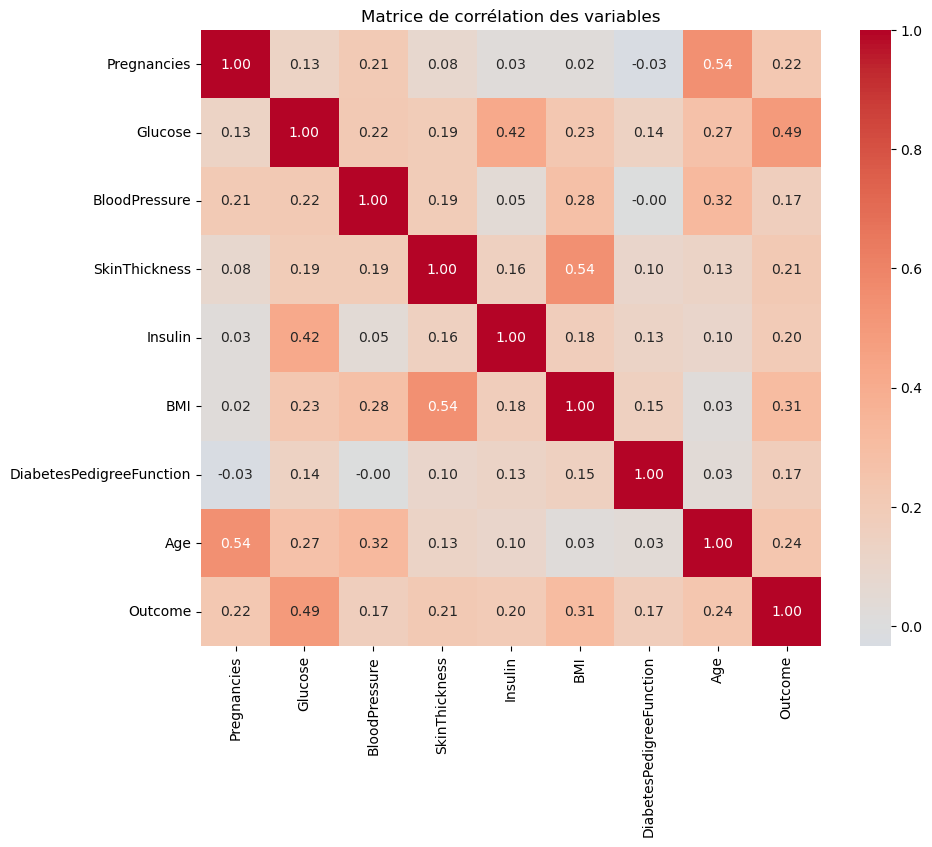

In [79]:
# **Matrice de corrélation**
plt.figure(figsize=(10, 8))
correlation_matrix = data_clean.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Matrice de corrélation des variables')
plt.show()

In [80]:
# **Statistiques descriptives par classe**
print("\nStatistiques descriptives par classe :")
stats_par_classe = data_clean.groupby('Outcome').describe()
print(stats_par_classe[['Glucose', 'BMI', 'Age', 'Insulin']].round(2))


Statistiques descriptives par classe :
        Glucose                                                     BMI  \
          count    mean    std   min    25%    50%    75%    max  count   
Outcome                                                                   
0         500.0  110.68  24.71  44.0   93.0  107.5  125.0  197.0  500.0   
1         268.0  142.13  29.57  78.0  119.0  140.0  167.0  199.0  268.0   

                ...   Age       Insulin                                      \
          mean  ...   75%   max   count    mean     std   min    25%    50%   
Outcome         ...                                                           
0        30.89  ...  37.0  81.0   500.0  127.79   74.45  15.0   95.0  125.0   
1        35.38  ...  44.0  70.0   268.0  164.70  100.93  14.0  125.0  125.0   

                        
            75%    max  
Outcome                 
0        125.00  744.0  
1        167.25  846.0  

[2 rows x 32 columns]


In [81]:
# ------------------------------------------------------------------------------
# 4. Split train/validation/test
# ------------------------------------------------------------------------------
print("\n4-SPLIT : Division train/validation/test (60%/20%/20%)...")


4-SPLIT : Division train/validation/test (60%/20%/20%)...


In [82]:
# **Séparer features et target**
X = data_clean.drop('Outcome', axis=1)
y = data_clean['Outcome']

# **Division stratifiée 60/20/20**
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"   Ensemble d'entraînement : {X_train.shape[0]} échantillons ({X_train.shape[0]/len(data_clean)*100:.1f}%)")
print(f"   Ensemble de validation : {X_val.shape[0]} échantillons ({X_val.shape[0]/len(data_clean)*100:.1f}%)")
print(f"   Ensemble de test : {X_test.shape[0]} échantillons ({X_test.shape[0]/len(data_clean)*100:.1f}%)")

print(f"\nDistribution des classes dans les ensembles :")
print(f"   Train : {dict(y_train.value_counts().sort_index())}")
print(f"   Validation : {dict(y_val.value_counts().sort_index())}")
print(f"   Test : {dict(y_test.value_counts().sort_index())}")

   Ensemble d'entraînement : 460 échantillons (59.9%)
   Ensemble de validation : 154 échantillons (20.1%)
   Ensemble de test : 154 échantillons (20.1%)

Distribution des classes dans les ensembles :
   Train : {0: 300, 1: 160}
   Validation : {0: 100, 1: 54}
   Test : {0: 100, 1: 54}


In [83]:
# ------------------------------------------------------------------------------
# 5. Feature engineering / sélection
# ------------------------------------------------------------------------------
print("\n5-FEATURE ENGINEERING : Standardisation des variables...")


5-FEATURE ENGINEERING : Standardisation des variables...


In [84]:
# **Standardisation des features**
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# **Convertir en DataFrame pour garder les noms**
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("   Variables standardisées (moyenne=0, écart-type=1)")
print(f"   Moyenne du train set : {X_train_scaled.mean().mean():.4f}")
print(f"   Écart-type du train set : {X_train_scaled.std().mean():.4f}")

   Variables standardisées (moyenne=0, écart-type=1)
   Moyenne du train set : 0.0000
   Écart-type du train set : 1.0011


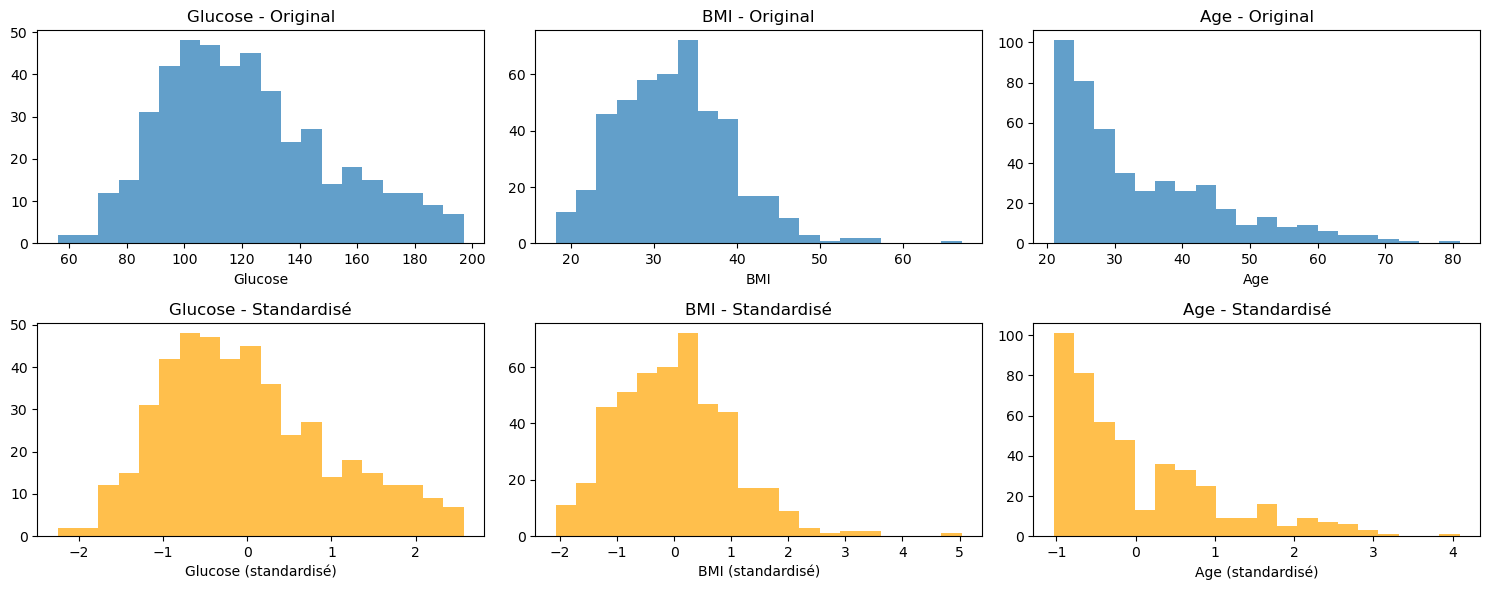

In [85]:
# **Visualisation avant/après standardisation**
plt.figure(figsize=(15, 6))
variables_exemples = ['Glucose', 'BMI', 'Age']

for i, var in enumerate(variables_exemples):
    plt.subplot(2, 3, i+1)
    plt.hist(X_train[var], bins=20, alpha=0.7, label='Original')
    plt.title(f'{var} - Original')
    plt.xlabel(var)
    
    plt.subplot(2, 3, i+4)
    plt.hist(X_train_scaled[var], bins=20, alpha=0.7, label='Standardisé', color='orange')
    plt.title(f'{var} - Standardisé')
    plt.xlabel(f'{var} (standardisé)')

plt.tight_layout()
plt.show()

In [86]:
# ------------------------------------------------------------------------------
# 6. Gestion du déséquilibre
# ------------------------------------------------------------------------------
print("\n6-DÉSÉQUILIBRE : Gestion avec SMOTE...")


6-DÉSÉQUILIBRE : Gestion avec SMOTE...


In [87]:
# **Appliquer SMOTE**
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"   Ensemble d'entraînement original : {len(y_train)} échantillons")
print(f"   Ensemble d'entraînement équilibré : {len(y_train_balanced)} échantillons")
print(f"   Distribution originale : {dict(y_train.value_counts().sort_index())}")
print(f"   Distribution équilibrée : {dict(pd.Series(y_train_balanced).value_counts().sort_index())}")


   Ensemble d'entraînement original : 460 échantillons
   Ensemble d'entraînement équilibré : 600 échantillons
   Distribution originale : {0: 300, 1: 160}
   Distribution équilibrée : {0: 300, 1: 300}


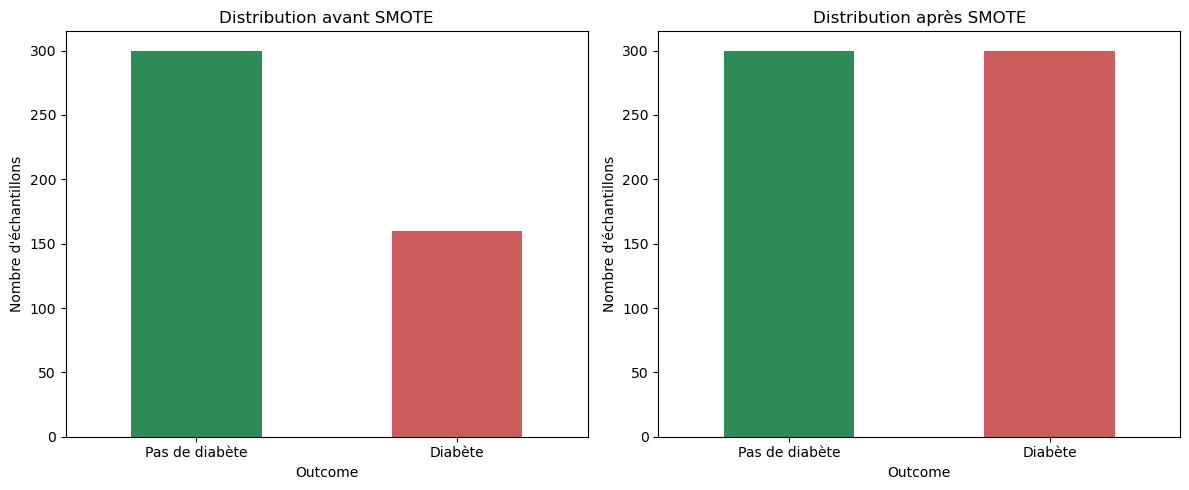

In [88]:
# **Visualisation de l'impact de SMOTE**
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color=['#2E8B57', '#CD5C5C'])
plt.title('Distribution avant SMOTE')
plt.xticks([0, 1], ['Pas de diabète', 'Diabète'], rotation=0)
plt.ylabel('Nombre d\'échantillons')

plt.subplot(1, 2, 2)
pd.Series(y_train_balanced).value_counts().sort_index().plot(kind='bar', color=['#2E8B57', '#CD5C5C'])
plt.title('Distribution après SMOTE')
plt.xticks([0, 1], ['Pas de diabète', 'Diabète'], rotation=0)
plt.ylabel('Nombre d\'échantillons')

plt.tight_layout()
plt.show()

In [89]:
# ------------------------------------------------------------------------------
# 7. Modélisation initiale : Logistic Regression
# ------------------------------------------------------------------------------
print("\n7-MODÉLISATION : Entraînement Régression Logistique...")


7-MODÉLISATION : Entraînement Régression Logistique...


In [90]:
# **Entraîner le modèle**
modele = LogisticRegression(random_state=42, max_iter=1000)
modele.fit(X_train_balanced, y_train_balanced)

# **Prédictions sur validation**
y_val_pred = modele.predict(X_val_scaled)
y_val_proba = modele.predict_proba(X_val_scaled)[:, 1]

# **Métriques sur validation**
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print(f"\nPerformance sur l'ensemble de validation :")
print(f"   Accuracy : {val_accuracy:.4f}")
print(f"   Précision : {val_precision:.4f}")
print(f"   Rappel : {val_recall:.4f}")
print(f"   F1-Score : {val_f1:.4f}")


Performance sur l'ensemble de validation :
   Accuracy : 0.7468
   Précision : 0.6316
   Rappel : 0.6667
   F1-Score : 0.6486


In [91]:
# ------------------------------------------------------------------------------
# 8. Évaluation finale
# ------------------------------------------------------------------------------
print("\n8-ÉVALUATION FINALE : Test set et matrice de confusion...")


8-ÉVALUATION FINALE : Test set et matrice de confusion...


In [92]:
# **Prédictions sur test**
y_test_pred = modele.predict(X_test_scaled)
y_test_proba = modele.predict_proba(X_test_scaled)[:, 1]

# **Métriques sur test**
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\nPerformance sur l'ensemble de test :")
print(f"   Accuracy : {test_accuracy:.4f}")
print(f"   Précision : {test_precision:.4f}")
print(f"   Rappel : {test_recall:.4f}")
print(f"   F1-Score : {test_f1:.4f}")


Performance sur l'ensemble de test :
   Accuracy : 0.7338
   Précision : 0.6000
   Rappel : 0.7222
   F1-Score : 0.6555


In [93]:
# **Rapport de classification détaillé**
print("\nRapport de classification détaillé :")
print(classification_report(y_test, y_test_pred, target_names=['Pas de diabète', 'Diabète']))


Rapport de classification détaillé :
                precision    recall  f1-score   support

Pas de diabète       0.83      0.74      0.78       100
       Diabète       0.60      0.72      0.66        54

      accuracy                           0.73       154
     macro avg       0.72      0.73      0.72       154
  weighted avg       0.75      0.73      0.74       154



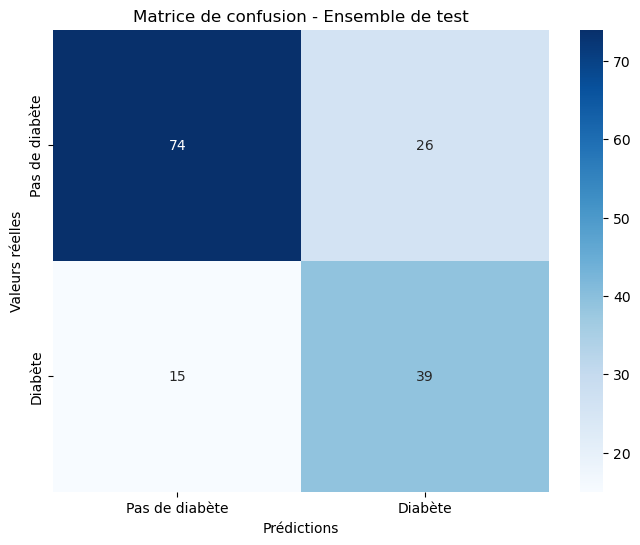


Détail de la matrice de confusion :
   Vrais négatifs (TN) : 74
   Faux positifs (FP) : 26
   Faux négatifs (FN) : 15
   Vrais positifs (TP) : 39


In [94]:
# **Matrice de confusion**
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pas de diabète', 'Diabète'],
            yticklabels=['Pas de diabète', 'Diabète'])
plt.title('Matrice de confusion - Ensemble de test')
plt.ylabel('Valeurs réelles')
plt.xlabel('Prédictions')
plt.show()

print(f"\nDétail de la matrice de confusion :")
print(f"   Vrais négatifs (TN) : {cm[0,0]}")
print(f"   Faux positifs (FP) : {cm[0,1]}")
print(f"   Faux négatifs (FN) : {cm[1,0]}")
print(f"   Vrais positifs (TP) : {cm[1,1]}")

In [95]:
# ------------------------------------------------------------------------------
# 9. Explainability
# ------------------------------------------------------------------------------
print("\n9-EXPLAINABILITY : Importance des features et analyse des erreurs...")


9-EXPLAINABILITY : Importance des features et analyse des erreurs...


In [96]:
# **Importance des features (coefficients)**
coefficients = modele.coef_[0]
importance_features = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\nImportance des features (coefficients de régression logistique) :")
print(importance_features)



Importance des features (coefficients de régression logistique) :
                    feature  coefficient  abs_coefficient
1                   Glucose     1.326532         1.326532
5                       BMI     0.931286         0.931286
0               Pregnancies     0.359858         0.359858
6  DiabetesPedigreeFunction     0.342056         0.342056
2             BloodPressure    -0.193119         0.193119
4                   Insulin    -0.137902         0.137902
3             SkinThickness    -0.130361         0.130361
7                       Age     0.097964         0.097964


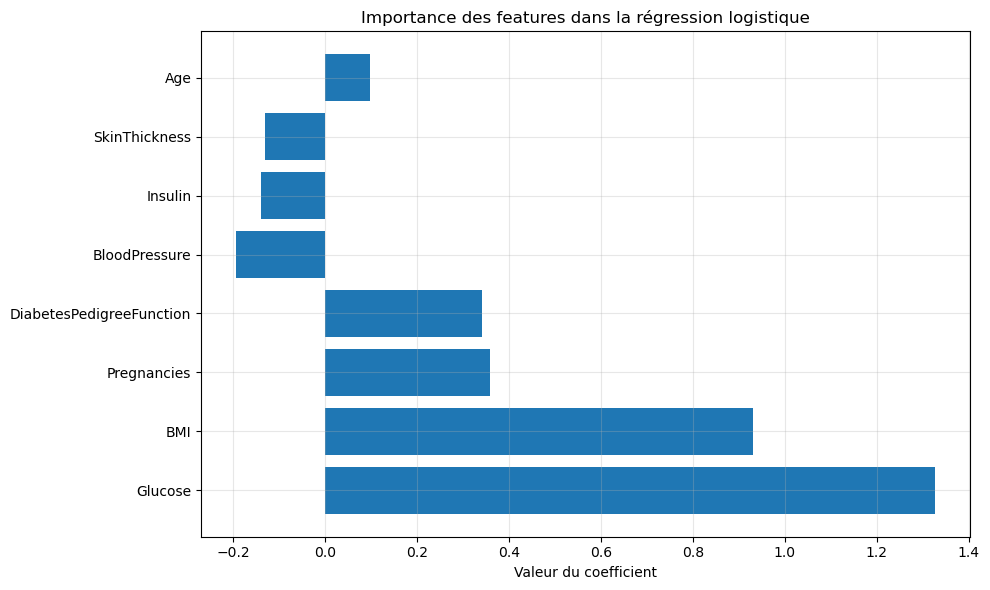

In [97]:
# **Visualisation importance**
plt.figure(figsize=(10, 6))
plt.barh(importance_features['feature'], importance_features['coefficient'])
plt.xlabel('Valeur du coefficient')
plt.title('Importance des features dans la régression logistique')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [98]:
# **Analyse des erreurs**
# Réinitialiser les indices pour éviter les erreurs d'indexation
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Identifier les erreurs
indices_faux_positifs = np.where((y_test_reset == 0) & (y_test_pred == 1))[0]
indices_faux_negatifs = np.where((y_test_reset == 1) & (y_test_pred == 0))[0]

nb_erreurs_total = len(indices_faux_positifs) + len(indices_faux_negatifs)

print(f"\nAnalyse des erreurs :")
print(f"   Erreurs totales : {nb_erreurs_total} ({nb_erreurs_total/len(y_test)*100:.1f}%)")
print(f"   Faux positifs : {len(indices_faux_positifs)} ({len(indices_faux_positifs)/len(y_test)*100:.1f}%)")
print(f"   Faux négatifs : {len(indices_faux_negatifs)} ({len(indices_faux_negatifs)/len(y_test)*100:.1f}%)")

if len(indices_faux_positifs) > 0:
    print("\nCaractéristiques moyennes des faux positifs :")
    print(X_test_reset.iloc[indices_faux_positifs].mean().round(2))

if len(indices_faux_negatifs) > 0:
    print("\nCaractéristiques moyennes des faux négatifs :")
    print(X_test_reset.iloc[indices_faux_negatifs].mean().round(2))


Analyse des erreurs :
   Erreurs totales : 41 (26.6%)
   Faux positifs : 26 (16.9%)
   Faux négatifs : 15 (9.7%)

Caractéristiques moyennes des faux positifs :
Pregnancies                   5.04
Glucose                     144.73
BloodPressure                77.19
SkinThickness                32.62
Insulin                     198.50
BMI                          36.80
DiabetesPedigreeFunction      0.44
Age                          35.58
dtype: float64

Caractéristiques moyennes des faux négatifs :
Pregnancies                   5.07
Glucose                     112.67
BloodPressure                68.67
SkinThickness                30.40
Insulin                     151.80
BMI                          31.01
DiabetesPedigreeFunction      0.43
Age                          32.67
dtype: float64


In [99]:
# ------------------------------------------------------------------------------
# 10. Conclusions
# ------------------------------------------------------------------------------
print("\n10-CONCLUSIONS : Synthèse et recommandations...")


10-CONCLUSIONS : Synthèse et recommandations...


In [100]:
print(f"""
**Résultats du modèle** :
- Accuracy sur test : {test_accuracy:.1%}
- F1-Score sur test : {test_f1:.1%}
- {len(indices_faux_positifs)} faux positifs et {len(indices_faux_negatifs)} faux négatifs sur {len(y_test)} prédictions

**Features les plus importantes** :
- {importance_features.iloc[0]['feature']} (coefficient: {importance_features.iloc[0]['coefficient']:.3f})
- {importance_features.iloc[1]['feature']} (coefficient: {importance_features.iloc[1]['coefficient']:.3f})
- {importance_features.iloc[2]['feature']} (coefficient: {importance_features.iloc[2]['coefficient']:.3f})

**Recommandations pour le déploiement** :
- Le modèle est prêt pour un déploiement pilote en contexte de dépistage
- Minimiser les faux négatifs en ajustant le seuil de décision si nécessaire
- Validation continue avec de nouvelles données

**Améliorations futures** :
- Tester des modèles ensemble (Random Forest, XGBoost)
- Validation croisée pour une évaluation plus robuste
- Collecte de features supplémentaires (historique familial, etc.)
""")


**Résultats du modèle** :
- Accuracy sur test : 73.4%
- F1-Score sur test : 65.5%
- 26 faux positifs et 15 faux négatifs sur 154 prédictions

**Features les plus importantes** :
- Glucose (coefficient: 1.327)
- BMI (coefficient: 0.931)
- Pregnancies (coefficient: 0.360)

**Recommandations pour le déploiement** :
- Le modèle est prêt pour un déploiement pilote en contexte de dépistage
- Minimiser les faux négatifs en ajustant le seuil de décision si nécessaire
- Validation continue avec de nouvelles données

**Améliorations futures** :
- Tester des modèles ensemble (Random Forest, XGBoost)
- Validation croisée pour une évaluation plus robuste
- Collecte de features supplémentaires (historique familial, etc.)



In [101]:
# Sauvegarde des données
data.to_csv("diabetes_classified.csv", index=False)
print("\n✅ Fichier sauvegardé : 'diabetes_classified.csv'")


✅ Fichier sauvegardé : 'diabetes_classified.csv'
